## Loading libs

In [17]:
import pandas as pd
import pprint
import glob
import csv
from os import listdir
from os.path import isfile, join, split

CONCAT_DIR = 'final_average/'

# Create df of full fps using glob to return all csv files under final dir
files = pd.DataFrame([file for file in glob.glob("final_runs/*/*.csv")], columns=["fullpath"])
print(len(files))
#    fullpath
# 0  final\run_1\*.csv
# 1  final\run_1\*.csv
# ..

# Split the full path into directory and filename
files_split = files['fullpath'].str.rsplit("/", 1, expand=True).rename(columns={0: 'path', 1:'filename'})

#    path       filename
# 0  final\run_1  *.csv
# 1  final\run_1  *.csv
# ..

# Join these into one DataFrame
files = files.join(files_split)

#    fullpath           path          filename
# 0  final\run_1\*.csv   final\run_1  *.csv
# 1  final\run_1\*.csv   final\run_1  *.csv
# ..




93


In [ ]:

# Iterate over unique filenames; read CSVs, concat DFs, save file
for fn in files['filename'].unique():

    paths = files[files['filename'] == fn]['fullpath'] # Get list of fullpaths from unique filenames
    dfs = []
    # dfs = [pd.read_csv(path, skiprows=[0], header=None, index_col=0) for path in paths] # Get list of dataframes from CSV file paths
    # Write headers
#     with open(CONCAT_DIR + fn, 'w') as fw: 

    header_df = pd.read_csv(paths.iloc[0])
    headers = list(header_df.columns.values)
    if not any(x in paths.iloc[0] for x in ['default', 'ompl']):
        headers.pop(0)
    print(headers)
#         writer = csv.writer(fw)
#         writer.writerow(list(header_df.columns.values))
    
    for path in paths:
        print(path)
        if not any(x in path for x in ['default', 'ompl']):
            dfs.append(pd.read_csv(path, skiprows=[0], header=None, index_col=0, sep=',').dropna(axis=1)) # Get list of dataframes from CSV file paths
        else:
            dfs.append(pd.read_csv(path, skiprows=[0], header=None)) # Get list of dataframes from CSV file paths
#     with open(CONCAT_DIR + fn, 'a') as fw:
    concat_df = pd.concat(dfs).reset_index(drop=True)  # Concat dataframes into one
    concat_df.to_csv(CONCAT_DIR + fn, header=headers) # Save dataframe

In [13]:

results_fps_1 = [file for file in glob.glob(join('final_runs', 'run_1', '*.csv'))]
print(len(results_fps_1))
pprint.pprint(results_fps_1)

44
['final_runs\\run_1\\Burger_etal_aucbandit_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_aucbandit_BKPIECE.csv',
 'final_runs\\run_1\\Burger_etal_aucbandit_RRTConnect.csv',
 'final_runs\\run_1\\Burger_etal_default.csv',
 'final_runs\\run_1\\Burger_etal_et_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_et_BKPIECE.csv',
 'final_runs\\run_1\\Burger_etal_et_RRTConnect.csv',
 'final_runs\\run_1\\Burger_etal_gbrt_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_gbrt_BKPIECE.csv',
 'final_runs\\run_1\\Burger_etal_gbrt_RRTConnect.csv',
 'final_runs\\run_1\\Burger_etal_gp_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_gp_BKPIECE.csv',
 'final_runs\\run_1\\Burger_etal_gp_RRTConnect.csv',
 'final_runs\\run_1\\Burger_etal_ompl.csv',
 'final_runs\\run_1\\Burger_etal_rand_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_rand_BKPIECE.csv',
 'final_runs\\run_1\\Burger_etal_rand_RRTConnect.csv',
 'final_runs\\run_1\\Burger_etal_rf_BiTRRT.csv',
 'final_runs\\run_1\\Burger_etal_rf_BKPIECE.csv',
 'final_runs\\

In [18]:

results_fps_2 = [file for file in glob.glob(join('final_runs', 'run_2', '*.csv'))]
print(len(results_fps_2))
pprint.pprint(results_fps_2)


40
['final_runs\\run_2\\Burger_etal_aucbandit_BiTRRT.csv',
 'final_runs\\run_2\\Burger_etal_aucbandit_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_aucbandit_RRTConnect.csv',
 'final_runs\\run_2\\Burger_etal_default.csv',
 'final_runs\\run_2\\Burger_etal_et_BiTRRT.csv',
 'final_runs\\run_2\\Burger_etal_et_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_et_RRTConnect.csv',
 'final_runs\\run_2\\Burger_etal_gbrt_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_gbrt_RRTConnect.csv',
 'final_runs\\run_2\\Burger_etal_ompl.csv',
 'final_runs\\run_2\\Burger_etal_rand_BiTRRT.csv',
 'final_runs\\run_2\\Burger_etal_rand_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_rand_RRTConnect.csv',
 'final_runs\\run_2\\Burger_etal_rf_BiTRRT.csv',
 'final_runs\\run_2\\Burger_etal_rf_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_rf_RRTConnect.csv',
 'final_runs\\run_2\\Burger_etal_smac_BiTRRT.csv',
 'final_runs\\run_2\\Burger_etal_smac_BKPIECE.csv',
 'final_runs\\run_2\\Burger_etal_smac_RRTConnect.csv',
 'fina

'final_runs\\run_2'

In [29]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

def factor_plot(fps, planner_select, planner, modes=None):
    fps = sorted(fps.copy())
    fig,ax = plt.subplots(1)
    cm = plt.get_cmap('jet')
    ax.set_prop_cycle('color', [cm(i) for i in np.linspace(0, 1, 10)])
    dir, fn = split(fps[0])
    
    elapsed_time = np.linspace(0, 7200, 500)
    default_fn = planner_select+'_default.csv'
    default_df = pd.read_csv(join(dir, default_fn), index_col=False)
    default = float(
        default_df[(default_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    default_df = pd.DataFrame(
        {'elapsed_time': elapsed_time, 'default': default})
    default_df['default'] = default/default_df['default']
    ax.plot('elapsed_time', 'default', data=default_df, label='default')

    ompl_fn = planner_select+'_ompl.csv'
    ompl_df = pd.read_csv(join(dir, ompl_fn), index_col=False)
    ompl = float(ompl_df[(ompl_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    ompl_df = pd.DataFrame({'elapsed_time': elapsed_time, 'ompl': ompl})
    ompl_df['ompl'] = default/ompl_df['ompl']
    ax.plot('elapsed_time', 'ompl', data=ompl_df, label='ompl')

    # Planner select filepaths
    for f in fps:
        if planner_select in f:
            if not any(x in f for x in ['default', 'ompl']):
                # f = <planner_select>_<mode>_<planner>.csv
                dir, fn = split(f)
                fn = fn.split('_')
                planner_fn = fn[-1].split('.')[-2]
                mode = fn[2]
                
                if (modes != None) and (mode not in modes):
                    fps.remove(f)
                else:
                    # Filtering fns for selected planner
                    if re.search(planner_fn, planner, re.IGNORECASE): 
#                         print(f)
                        mode_df = pd.read_csv(f, index_col=False)
                        # Remove everything slower than ompl baseline
                        # mode_df.drop(mode_df[mode_df.loss >= ompl].index, inplace=True)
                        max_speed_up = ompl
                        speed_up = list(mode_df['loss'])
                        for idx, loss in enumerate(speed_up):
                            if loss < max_speed_up:
                                max_speed_up = loss
                            else:
                                speed_up[idx] = max_speed_up
                                                                   
                        mode_df = pd.DataFrame({'elapsed_time': mode_df['elapsed_time'], mode: speed_up})
                        mode_df[mode+'_factor'] = ompl/mode_df[mode]
                        ax.plot('elapsed_time', mode+'_factor', data=mode_df, label=mode+'_factor')

    
    plt.title(planner_select + ' ' + planner)
    plt.xticks([0, 1440, 2880, 4320, 5760, 7200])
    #                     plt.yticks([0.8, 1.6, 2.4, 3.1, 3.9, 4.7])
    plt.xlabel('Time spent exploring solutions (secs)')
    plt.ylabel('Speed up over default (secs)')
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles,labels,loc='upper right')
    plt.show()

In [68]:
# Resampling data
# https://towardsdatascience.com/preprocessing-iot-data-linear-resampling-dde750910531
import datetime

resampled_dir = 'resampled'
resampled_df = results_fps_2[0]
# for f in results_fps_2:
df = pd.read_csv(results_fps_2[2])
df.head()

print(type(datetime.timedelta(seconds=20.845424)))
print(str(datetime.timedelta(seconds=2000.845424)))
# for i in range(7200):
#     pass
   

<class 'datetime.timedelta'>
0:33:20.845424


## Speedup Factor Plots

### Cano_etal BKPIECE

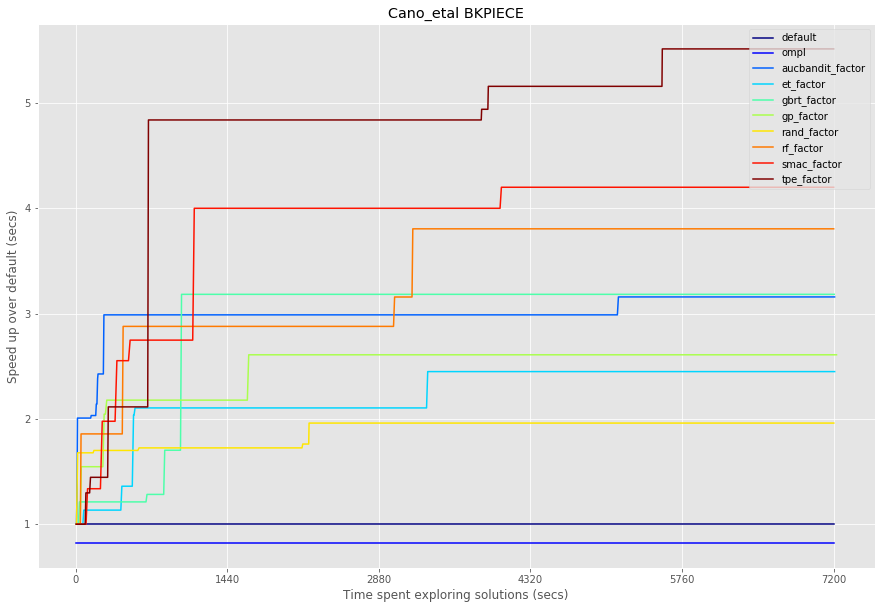

In [30]:
factor_plot(results_fps_1, 'Cano_etal', 'BKPIECE')

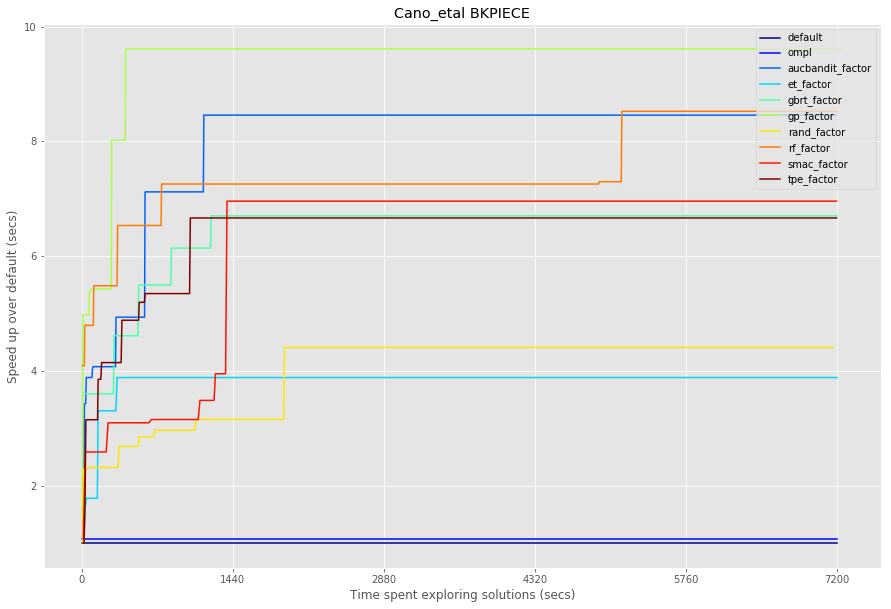

In [31]:
factor_plot(results_fps_2, 'Cano_etal', 'BKPIECE')

### Cano_etal RRTConnect


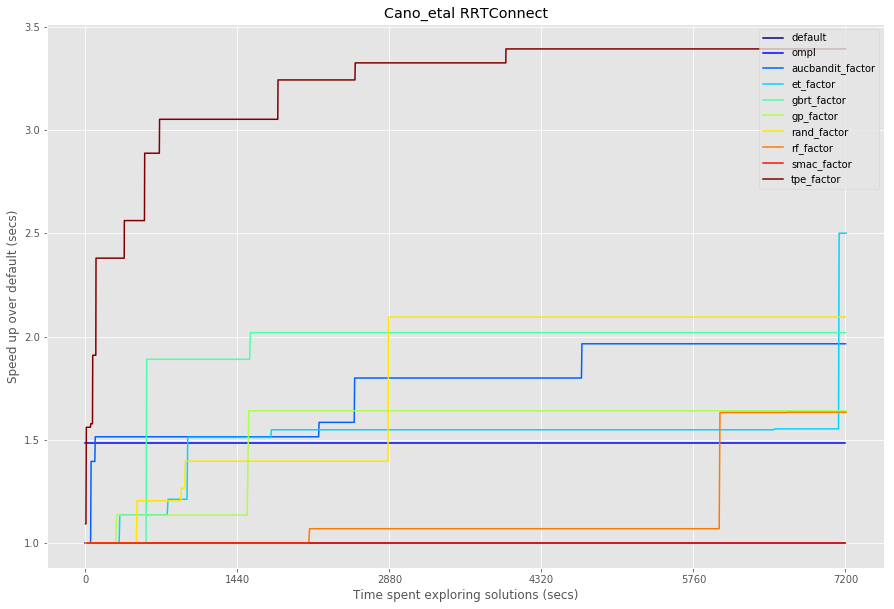

In [32]:
factor_plot(results_fps_1, 'Cano_etal', 'RRTConnect')

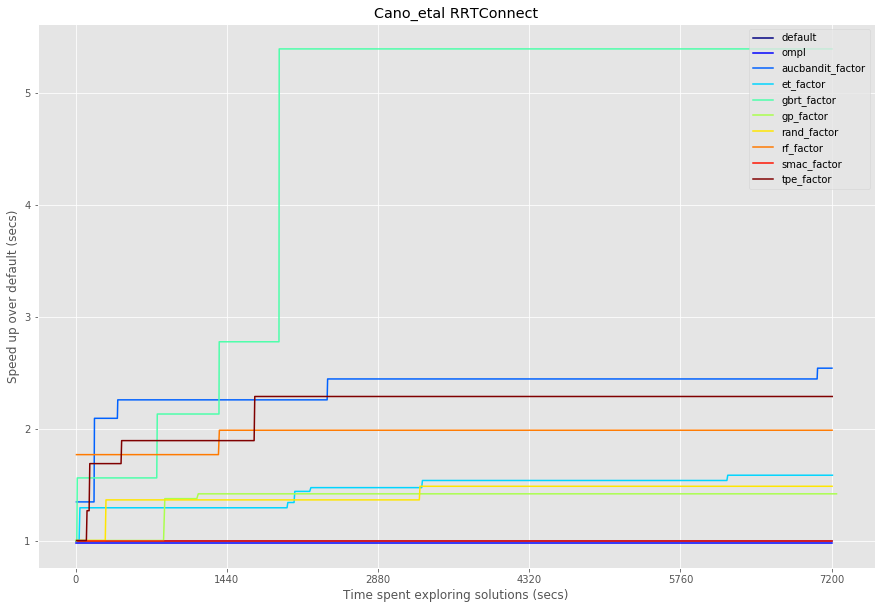

In [9]:
factor_plot(results_fps_2, 'Cano_etal', 'RRTConnect')

### Burger_etal BKPIECE

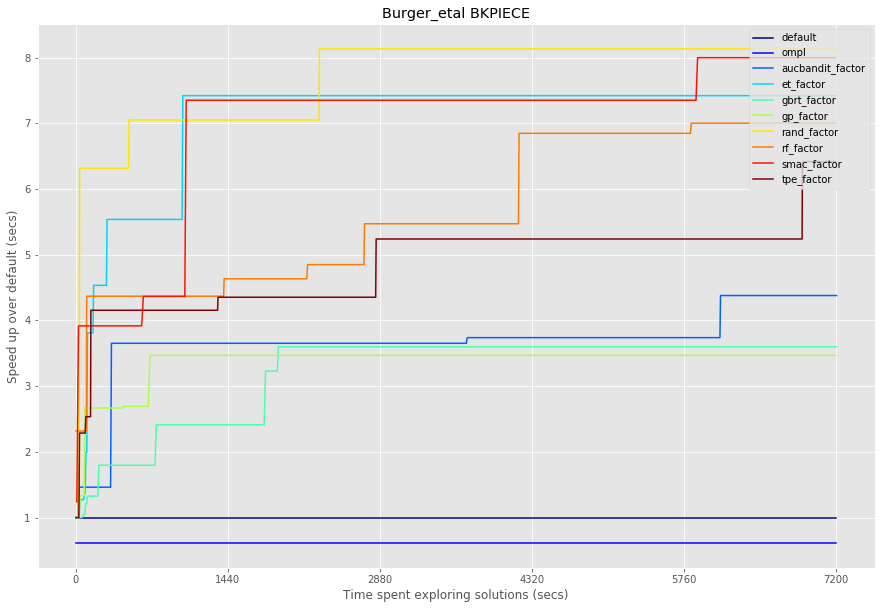

In [33]:
factor_plot(results_fps_1, 'Burger_etal', 'BKPIECE')

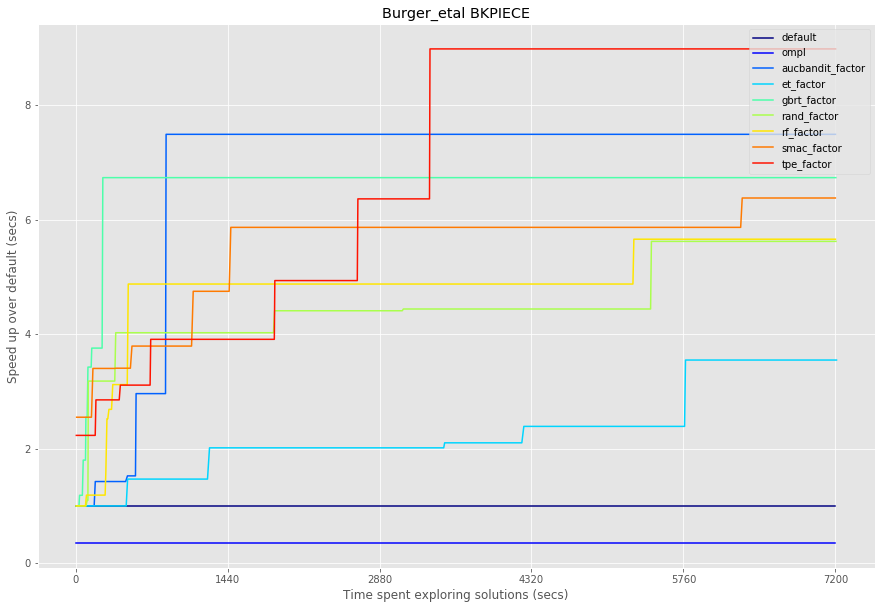

In [10]:
factor_plot(results_fps_2, 'Burger_etal', 'BKPIECE')

### Burger_etal RRTConnect

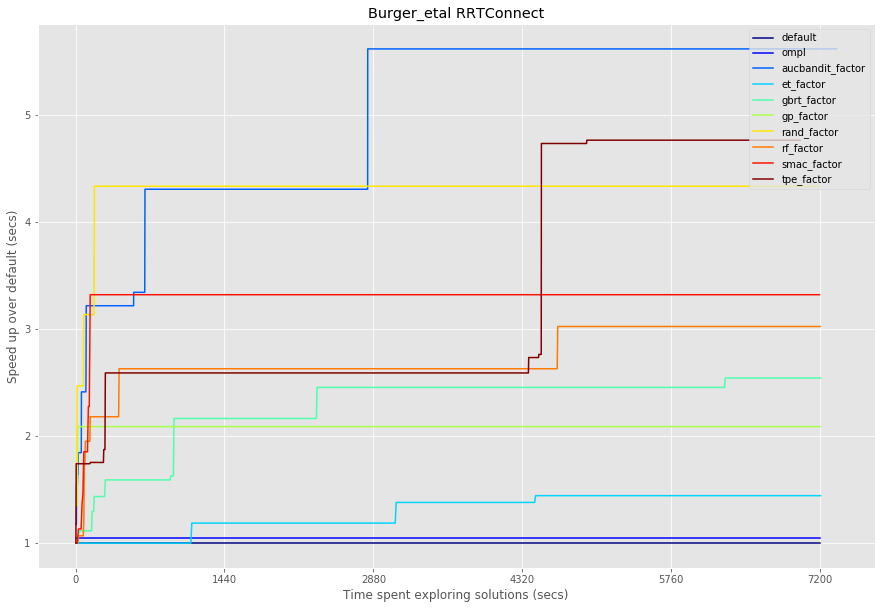

In [34]:
factor_plot(results_fps_1, 'Burger_etal', 'RRTConnect')

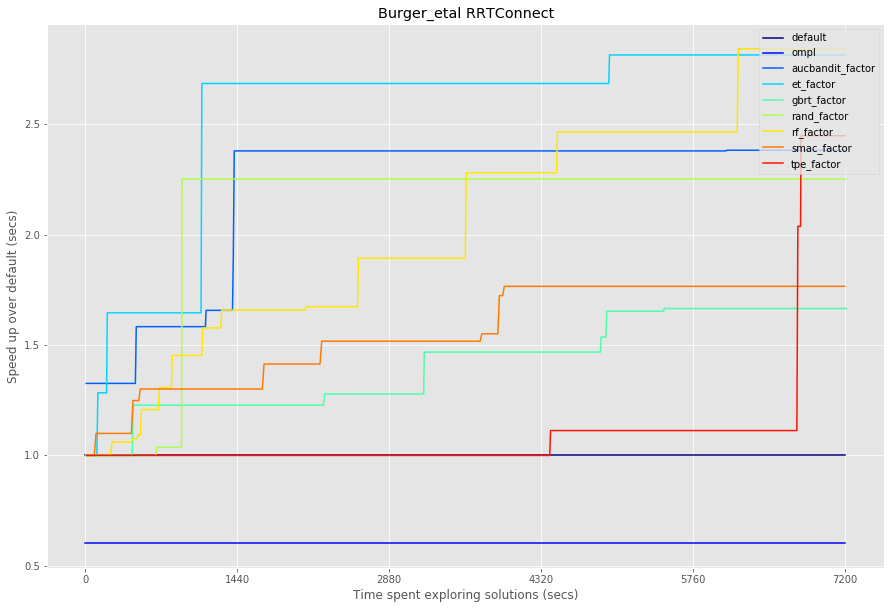

In [35]:
factor_plot(results_fps_2, 'Burger_etal', 'RRTConnect')

### Burger_etal BiTRRT

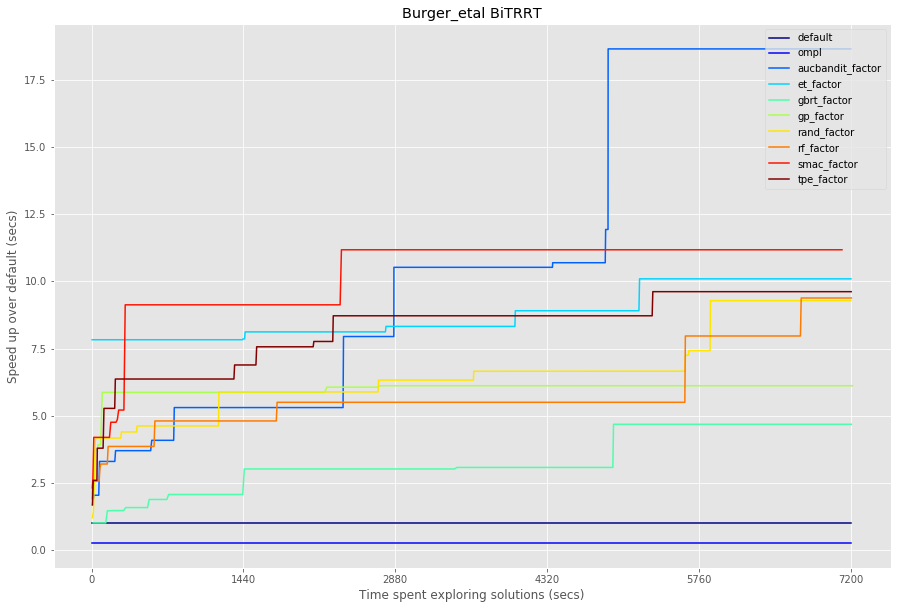

In [36]:
factor_plot(results_fps_1, 'Burger_etal', 'BiTRRT')

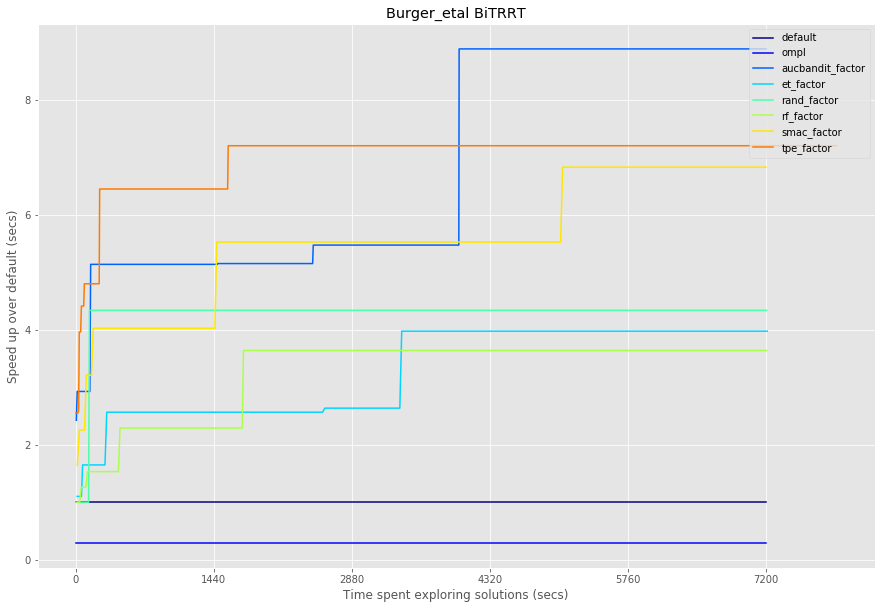

In [37]:
factor_plot(results_fps_2, 'Burger_etal', 'BiTRRT')